This is a simple example of how the various parts of the package can be combined to learn a sampling pattern.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch


In [2]:
%pylab inline
from bilevelmri.experiment_setup import learn, compute_statistics


Populating the interactive namespace from numpy and matplotlib


In [3]:
from bilevelmri.linear_ops.gradients import Grad
from bilevelmri.functionals import Smoothed1Norm
from bilevelmri.loss_functions import least_squares
from bilevelmri.penalty_functions import l1_disc_penalty
from bilevelmri.parametrisations import alpha_parametrisation, free_parametrisation

In [4]:
import torch

torch.set_default_dtype(torch.float64)

In [5]:
import SimpleITK as sitk
import skimage.io as io


In [6]:
path = 'C:\\Users\\Zhiya\\Desktop\\LMU_WS2122\\Bachlor Thesis\\Liturature\\bilevelmri\\image\\sub-093-anat-sub-093_run-01_T1w.nii.gz'
PREimg = sitk.ReadImage(path)
PREdata = sitk.GetArrayFromImage(PREimg)

In [7]:
rawImage = PREdata[50]
MavVl = double(np.amax(rawImage))
rawImage = rawImage / MavVl

In [8]:
np.amax(rawImage)

1.0

In [9]:
image = torch.tensor(rawImage)

In [10]:
#image = torch.tensor(PREdata[115])
x = torch.zeros(1,256,256,2)
x[0,:,:,0] = image
#for i in range(10):
#    x[i,:,:,0] = torch.tensor(PREdata[35+i])


y = torch.fft(x, signal_ndim=2, normalized=True) + 0.03 * torch.randn_like(x)
data = {'x': x, 'y': y}
n1, n2 = x.shape[1:3]

C:\Users\Zhiya\AppData\Local\Temp\ipykernel_5940\3542643308.py:8: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  ..\aten\src\ATen\native\SpectralOps.cpp:567.)
  y = torch.fft(x, signal_ndim=2, normalized=True) + 0.03 * torch.randn_like(x)


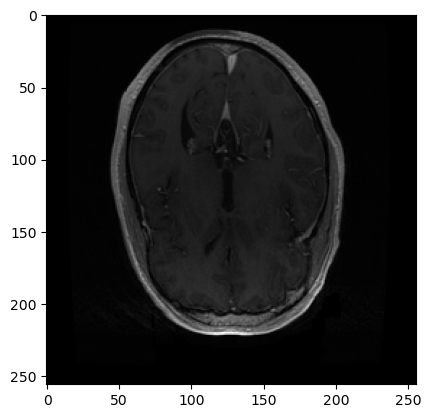

In [12]:
a = imshow(x[0,:,:,0], cmap='gray')

In [17]:
imsave('tstete.png', x[0,:,:,0], cmap = 'gray')

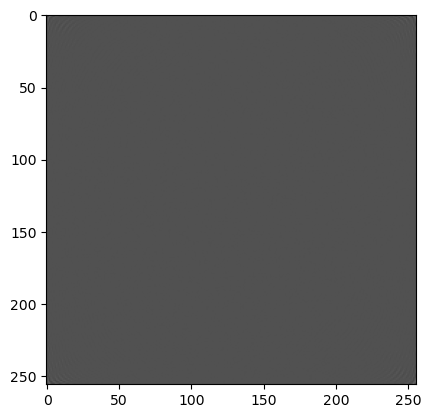

In [ ]:
imshow(y[0,:,:,0], cmap='gray')

In [ ]:
y[0,:,:,0]

tensor([[17.6749, -8.1863, -2.0212,  ...,  0.5200, -2.0280, -8.2257],
        [-2.9472, -0.5822,  2.1690,  ..., -0.6109,  2.6674,  0.4660],
        [-3.5777,  1.9798,  0.4249,  ..., -1.2939,  0.2445,  2.1857],
        ...,
        [-1.9915,  1.5288, -1.0504,  ..., -0.1360, -0.9038,  1.7981],
        [-3.5682,  2.1762,  0.2186,  ..., -0.9103,  0.4167,  2.0652],
        [-2.8991,  0.4378,  2.6556,  ...,  0.4845,  2.2263, -0.5932]])

In [ ]:
#x = torch.zeros(1, 32, 32, 2)
#x[0, 8:24, 8:24, 0] = 1.
#y = torch.fft(x, signal_ndim=2, normalized=True) + 0.03 * torch.randn_like(x)
#data = {'x': x, 'y': y}
#n1, n2 = x.shape[1:3]

In [ ]:
params = {
    'model': {
        'n1': n1,
        'n2': n2
    },
    'alg_params': {
        'll_sol': {
            'maxit': 1000,
            'tol': 1e-10
        },
        'lin_sys': {
            'maxit': 1000,
            'tol': 1e-6
        },
        'LBFGSB': {
            'maxit': 1000,
            'pgtol': 1e-8
        }
    }
}

A = Grad()
reg_func = Smoothed1Norm(gamma=1e-2)


def penalty(p):
    return l1_disc_penalty(p[:-2], beta=(.1, .1))

In [ ]:
# tune alpha on full sampling pattern to get initialisation
tuned_alpha = learn(data, 1e-3, [(0, np.inf)], alpha_parametrisation, A,
                    reg_func, least_squares, lambda p: torch.zeros_like(p),
                    params)

Learning sampling pattern:
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 1.49e-04
Iteration 250: Relative error: 3.49e-09
Finishing at iteration 286: Relative error: 8.22e-11
CG converged within tolerance 1.00e-06 at iteration 5: relative error was 6.70e-07
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 5.90e-04
Iteration 250: Relative error: 7.14e-05
Iteration 375: Relative error: 1.05e-05
Iteration 500: Relative error: 1.65e-06
Iteration 625: Relative error: 2.68e-07
Iteration 750: Relative error: 4.47e-08
Iteration 875: Relative error: 7.58e-09
Iteration 1000: Relative error: 1.30e-09
CG converged within tolerance 1.00e-06 at iteration 73: relative error was 9.25e-07

Iteration #1: Current sampling rate 100.0%, alpha 6.97e-02, eps 1.00e-02
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 4.04e-04
Iteration 250: Relative error: 3.77e-05
Iteration 37

In [ ]:
tuned_alpha

{'elapsed_time': datetime.timedelta(seconds=1113, microseconds=597479),
 'p': array([0.02982907]),
 'info': {'grad': array([1.05806227e-09]),
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'funcalls': 12,
  'nit': 6,
  'warnflag': 0}}

In [ ]:
p_init = np.ones(n1 * n2 + 2)
p_init[-1] = 1e-2
p_init[-2] = tuned_alpha['p']
p_bounds = [(0., 1.) for _ in range(n1 * n2)]
p_bounds.append((0, np.inf))
p_bounds.append((1e-2, 1e-2))
# learn sampling pattern
result = learn(data, p_init, p_bounds, free_parametrisation, A, reg_func,
               least_squares, penalty, params)

stats = compute_statistics(data, result['p'], A, reg_func, free_parametrisation, params)

Learning sampling pattern:
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 8.82e-05
Iteration 250: Relative error: 2.43e-06
Iteration 375: Relative error: 9.75e-08
Iteration 500: Relative error: 4.59e-09
Iteration 625: Relative error: 2.37e-10
Finishing at iteration 662: Relative error: 1.00e-10
CG converged within tolerance 1.00e-06 at iteration 45: relative error was 8.23e-07
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 8.82e-05
Iteration 250: Relative error: 2.43e-06
Iteration 375: Relative error: 9.75e-08
Iteration 500: Relative error: 4.59e-09
Iteration 625: Relative error: 2.37e-10
Finishing at iteration 662: Relative error: 1.00e-10
CG converged within tolerance 1.00e-06 at iteration 45: relative error was 8.23e-07

Iteration #1: Current sampling rate 100.0%, alpha 2.98e-02, eps 1.00e-02
Solver for lower level problem running on minibatch of size 1
Iteration 125: Relative error: 8.82e-05

KeyboardInterrupt: 

In [ ]:
result

In [ ]:
rcParams['figure.figsize'] = (15, 15)
subplot(1, 3, 1)
imshow(torch.sqrt(torch.sum(data['x'][0, :, :, :]**2, dim=2)), cmap='gray')
title('Ground truth')
subplot(1, 3, 2)
imshow(fftshift(result['p'][:-2].reshape(n1, n2)), cmap='gray')
title('Learned pattern')
subplot(1, 3, 3)
imshow(torch.sqrt(torch.sum(stats['recons'][0, :, :, :]**2, dim=2)), cmap='gray')
title('Reconstruction with learned pattern')